# Overlaying an Image onto the Earth

Welcome to the **Overlaying an Image** notebook! In this tutorial, we will explore how to add custom image overlays onto a 3D model of the Earth using the **accessvis** package. Overlaying data, such as satellite imagery, onto the Earth’s surface can help visualize real-world phenomena like cloud cover, ice coverage, or other environmental changes.

This notebook covers the following key concepts:

- **Downloading the Data**: We will download an example satellite image from NASA, showing cloud and ice cover over Earth on 2024-09-25.
- **Loading the Data**: We will load this data from a file and prepare it for use in the visualisation.
- **Overlaying the Data**: Learn how to add colour data to the Earth’s surface to represent the cloud and ice cover.

Overlaying images is essential for adding real-world data to visualisations, improving the accuracy and context of the visual representation. By the end of this notebook, you will understand how to overlay images and use satellite data to enrich your Earth visualisations.

## Initial Setup

In [1]:
import accessvis
import time
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('Ultra-hig…


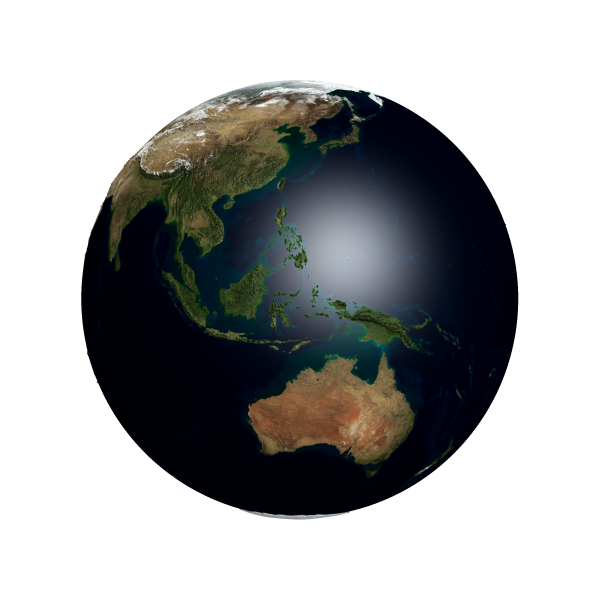

In [2]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(0.0, -125.0, 0.0) #Rotate to Australia
lv.display(resolution=(600,600))

## Downloading the Test Image

In this section, we will download a snapshot image from NASA's Earth Observing System Data and Information System (EOSDIS). The image shows the **True Colour** reflectance of Earth from the **VIIRS NOAA-20** satellite, taken on **2024-09-25**. This satellite provides valuable data on Earth's surface, including cloud cover, ice, and other atmospheric and environmental features.

We are using NASA’s **Worldview** API to fetch the image. Worldview is a tool that provides near real-time satellite imagery, and the image we are downloading is formatted as a JPEG for visualisation purposes.

The data used here is sourced from NASA’s Earth Observing System Data and Information System (EOSDIS). You can find more about the Worldview API and the imagery it provides on the [NASA Worldview page](https://worldview.earthdata.nasa.gov/).

We will be downloading the image, saving it to the local directory, and using it as a base for overlaying onto our 3D Earth visualisation.

Note: You may need to adjust the file path to point to the correct folder where you want to store the image locally.

In [3]:
baseurl = 'https://wvs.earthdata.nasa.gov/api/v1/snapshot?'
params = {'REQUEST': 'GetSnapshot',
          'LAYERS': 'VIIRS_NOAA20_CorrectedReflectance_TrueColor',
          'CRS': 'EPSG:4326',
          'TIME': '2024-09-25',
          'WRAP': 'DAY',
          'BBOX': '-90,-180,90,180',
          'FORMAT': 'image/jpeg',
          'WIDTH': 8192,
          'HEIGHT': 4096,
          'AUTOSCALE': 'TRUE',
          'ts': int(time.time()*1000)
         }
plist = [f"{p}={params[p]}" for p in params]
url = baseurl + '&'.join(plist)
url

fn = os.path.abspath('worldview_earth_snapshot.jpg')

if not os.path.exists(fn):
    accessvis.download(url, filename=fn)

## Loading the Image

After downloading the image, we need to address a **180-degree offset** in its coordinate system. The image's longitudes are reversed, so the prime meridian (0°) is at the far right.

To align the image correctly with the Earth's coordinate system, we will **roll** the image data horizontally, ensuring it matches the Earth’s surface when overlaid.

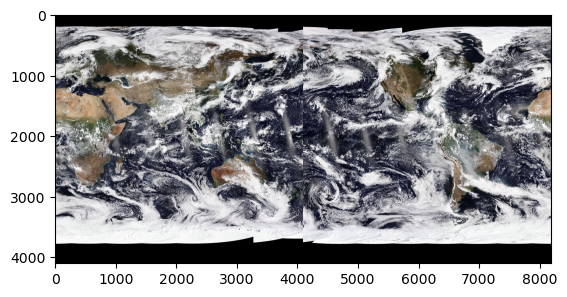

In [4]:
img = Image.open(fn)
arr = np.array(img)
arr = np.roll(arr, arr.shape[1] // 2, axis=1)
plt.imshow(arr)

## Formatting the Image

To make the clouds and ice more visible, we adjust their transparency, enhancing their contrast against the Earth's surface. This step is optional and purely for aesthetic purposes, helping to make the overlay more visually striking.

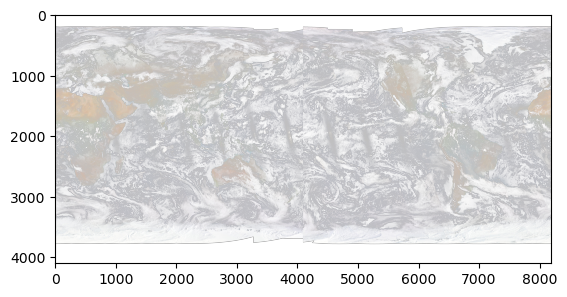

In [5]:
#Use approximate luminance for opacity (so darker = transparent)
#This will reduce the data to mostly clouds and ice areas to overlay over our existing texture
alpha = (0.33*arr[:,:,0] + 0.5*arr[:,:,1] + 0.16*arr[:,:,2]).astype(np.uint8)

#Combine the calculated alpha channel with the rgb data
arr2 = np.dstack((arr, alpha))
plt.imshow(arr2)

### Overlaying the Image Data

In this step, we overlay the processed image onto the Earth. We use `dataMode=0`, which ensures the image is applied to both land and ocean surfaces. This allows for a seamless integration of the cloud and ice cover data across the entire globe.




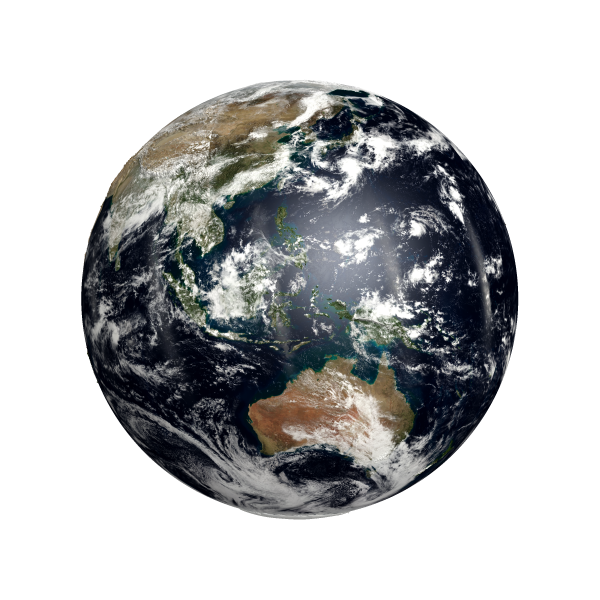

In [7]:
accessvis.update_earth_values(lv, dataMode=0, data=arr2)
lv.display(resolution=(600, 600))

In [8]:
lv.window(resolution=(600,600))